# Transfer Learning and Mobilenet Model



### 1. Loading and exploring the Dataset

**[1.1]**
First we need to import the SSL module and disable default certificate verfication

In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Solution
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**[1.2]** First we need to import the relevant class and libraries from PyTorch including 'os' in python.

In [4]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Solution
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

**[1.3]** Apply transformation using compose class to the image. This time we will not only normalize the images but we will also perform some data transformation such as Resize (image_size, image_size).

In [7]:
import torchvision.transforms as transforms

# Define normalization transform
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],   # Mean of ImageNet dataset
    std=[0.229, 0.224, 0.225]     # Standard deviation of ImageNet dataset
)
image_size = 224

# Apply normalization to the existing transforms with additional augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Zoom range equivalent
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomVerticalFlip(),  # Vertical flip (if needed, not in the original Keras params)
    transforms.RandomRotation(40),  # Rotation range
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=20),  # Width/height shift and shear range
    transforms.ToTensor(),
    normalize  # Applying normalization
])

# Update the transform for validation and test datasets to include normalization
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    normalize  # Applying normalization
])

**[1.4]**
Now need to mount taz file.

In [8]:
# pip install gdown

In [9]:
# import gdown

# # Direct download link obtained by modifying the original URL
# url = 'https://drive.google.com/drive/folders/18Rkqj4mmme2MoK3ybi2pY56VJ7JaWQcv'

# # Specify the name of the output file with .tar.gz extension
# output = 'food-101.tar.gz'

# # Download the file
# gdown.download(url, output, quiet=False)

In [10]:
# import tarfile

# # Path to the .tar.gz file
# file_path = 'food-101'  # Update the file path if necessary

# # Extract the contents of the .tar.gz file
# with tarfile.open(file_path, 'r:gz') as tar:
#     tar.extractall('/kaggle/working/')


In [11]:
# import tarfile

# # Path to the .tar.gz file
# file_path = 'food-101'  # Update the file path if necessary

# # Extract the contents of the .tar.gz file
# with tarfile.open(file_path, 'r:gz') as tar:
#     tar.extractall('/kaggle/working/')


In [12]:
# pip install kaggle

In [13]:
dataset_dir = '/kaggle/input/food101/food-101'

**[1.5]** Building Path DataFrame from Text Files

In [14]:
from pathlib import Path

path = Path(dataset_dir)
path_meta = path / 'meta'
path_images = path / 'images'

In [15]:
import pandas as pd
from pathlib import Path

def build_data_frame(path_name, img_folder='images', img_format='jpg'):
    """
    build_data_frame input the path and file name, the function will return the dataframe with two columns:
    ['label'] : image label
    ['image_file'] : image file name with directory information
    input parameters:
    path_name : path to the file containing the data
    img_folder : folder name where images are stored, default is 'images'
    img_format : default format is jpg

    return dataframe
    """
    path_name = Path(path_name)  # Convert path_name to a Path object
    file_df = pd.read_csv(path_name, delimiter='/', header=None, names=['label', 'image_file'])

    image_files = []
    for index, row in file_df.iterrows():
        image_file = Path('/kaggle/input/food101/food-101') / img_folder / str(row['label']) / (str(row['image_file']) + '.' + img_format)
        image_files.append(image_file)

    file_df['image_file'] = image_files

    return file_df

In [16]:
# import os

# directory = 'https://www.kaggle.com/datasets/thhibi/food-101'

# # Check if the directory exists
# if os.path.exists(directory):
#     # List all files in the directory
#     files = os.listdir(directory)

#     if files:
#         print("Files in directory '{}':".format(directory))
#         for file in files:
#             print(file)
#     else:
#         print("No files found in directory '{}'.".format(directory))
# else:
#     print("Directory '{}' does not exist.".format(directory))


In [17]:
train_df = build_data_frame('/kaggle/input/food101/food-101/meta/train.txt')
test_df = build_data_frame('/kaggle/input/food101/food-101/meta/test.txt')

In [18]:
train_df.head()

,label,image_file
0,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
1,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
2,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
3,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
4,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...


In [19]:
len(train_df)

75750

In [20]:
test_df.head()

,label,image_file
0,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
1,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
2,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
3,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
4,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...


In [21]:
len(test_df)

25250

In [22]:
# # Define the root folder where all the images are stored
# root_folder = '/food-101/images'

### 2.   Preparing the Dataset

**[2.1]** Filtering and Splitting Image Data

In [23]:
train_df

,label,image_file
0,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
1,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
2,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
3,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
4,apple_pie,/kaggle/input/food101/food-101/images/apple_pi...
...,...,...
75745,waffles,/kaggle/input/food101/food-101/images/waffles/...
75746,waffles,/kaggle/input/food101/food-101/images/waffles/...
75747,waffles,/kaggle/input/food101/food-101/images/waffles/...
75748,waffles,/kaggle/input/food101/food-101/images/waffles/...


In [24]:
# Define a function to filter images based on DataFrame
def filter_images(df):
    filtered_images = [(row['image_file'], row['label']) for index, row in df.iterrows()]
    return filtered_images

# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)

In [25]:
from sklearn.model_selection import train_test_split
#Split test_images into validation and testing sets (50/50 ratio)
validation_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

In [26]:
import random
def sample_dataset(dataset, fraction=1):

    num_samples = int(len(dataset) * fraction)
    sampled_data = random.sample(dataset, num_samples)
    return sampled_data


In [27]:
len(train_images)

75750

In [28]:
len(test_images)

12625

In [29]:
len(validation_images)

12625

**[2.3]**  Now we will call the DataLoader function that iteratively loads data based on batch size, shuffle and save it into three different variables called `train_loader`, `val_loader` and `test_loader`. Set the `BATCH_SIZE` to 128. The shuffle is a boolean variable. By default the shuffle value is false. If the shuffle is `True` means that the data is randomly shuffled before each epoch, so the order of the data is different in each epoch. (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [30]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split

In [31]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

class CustomDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

        # Create a dictionary to map class names to integer indices
        self.class_to_index = {class_name: index for index, class_name in enumerate(set(label for _, label in data))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        img_path = os.path.join(self.root_dir, image_path)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label_index = self.class_to_index[label]
        label_tensor = torch.tensor(label_index)  # Convert label to tensor

        return image, label_tensor

In [32]:
# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)

In [33]:
from sklearn.model_selection import train_test_split

# Split test_images into validation and testing sets
validation_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

In [34]:
# Create custom datasets for training, validation, and testing sets
train_dataset = CustomDataset(train_images, root_dir='/kaggle/input/food101/food-101/images', transform=train_transform)
validation_dataset = CustomDataset(validation_images, root_dir='/kaggle/input/food101/food-101/images', transform=transform)
test_dataset = CustomDataset(test_images, root_dir='/kaggle/input/food101/food-101/images', transform=transform)

In [35]:
len(train_dataset)

75750

In [36]:
len(test_dataset)

12625

In [37]:
len(validation_dataset)

12625

In [38]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 256

# Create DataLoader objects for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4) #The num_workers parameter specifies the number of subprocesses, which enables multi-process data loading
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


**[2.4]**  Let's have a look at the length of `train_set`, `val_set`, and `test_set`.

In [39]:
# Print sizes of datasets
print("Training set size:", len(train_dataset))
print("Validation set size:", len(validation_dataset))
print("Test set size:", len(test_dataset))

Training set size: 75750
Validation set size: 12625
Test set size: 12625


# 3: Defining the Architecture of MobileNet

**[3.1]** Import `torch.nn` as `nn`, and to import MobilenetV3 architecture we need to import `torchcision.models` as `models`

In [40]:
# Solution
import torch.nn as nn
import torchvision.models 

In [41]:
from torchvision.models import mobilenet_v3_large

**[3.2]** Now we will initialize the Mobilenet model by specifying the parameter `pretrained = True`, and perform head modification for Classification Task

In [67]:
# Initialize MobileNet with pre-trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load MobileNetV3-Large model
mobilenet_model = mobilenet_v3_large(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [68]:
mobilenet_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

**[3.3]** Let's have a look at the MobileNet architecture

##### Task: Print the summary of the Mobile Model

In [69]:
# %pip install torchsummary

The modified Mobilenet architecture includes three additional fully connected layers after the existing `AdaptiveAvgPool2d` layer. The `AdaptiveAvgPool2d` layer automatically adapts to the input size and performs average pooling, resulting in a fixed-size output regardless of the input size. Therefore, there's no need to explicitly add a `global average pooling layer` when modifying the classification head.


**[3.4]** Let's all layers of the model except the head by setting the value of `requires_grad` as `false`, i.e. no changes happen to its parameters. (https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html#torch.Tensor.requires_grad)

In [70]:
for idx, (name, param) in enumerate(mobilenet_model.named_parameters()):  # Iterate through named parameters of the model
    param.requires_grad = False  # Set requires_grad to False to freeze the parameter
    
# Verify which parameters are frozen
for name, param in mobilenet_model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

features.0.0.weight: requires_grad=False
features.0.1.weight: requires_grad=False
features.0.1.bias: requires_grad=False
features.1.block.0.0.weight: requires_grad=False
features.1.block.0.1.weight: requires_grad=False
features.1.block.0.1.bias: requires_grad=False
features.1.block.1.0.weight: requires_grad=False
features.1.block.1.1.weight: requires_grad=False
features.1.block.1.1.bias: requires_grad=False
features.2.block.0.0.weight: requires_grad=False
features.2.block.0.1.weight: requires_grad=False
features.2.block.0.1.bias: requires_grad=False
features.2.block.1.0.weight: requires_grad=False
features.2.block.1.1.weight: requires_grad=False
features.2.block.1.1.bias: requires_grad=False
features.2.block.2.0.weight: requires_grad=False
features.2.block.2.1.weight: requires_grad=False
features.2.block.2.1.bias: requires_grad=False
features.3.block.0.0.weight: requires_grad=False
features.3.block.0.1.weight: requires_grad=False
features.3.block.0.1.bias: requires_grad=False
features.

In [71]:
# Get unique labels from training, validation, and test datasets
train_labels = [label for _, label in train_images]
validation_labels = [label for _, label in validation_images]
test_labels = [label for _, label in test_images]

# Combine labels from all datasets
all_labels = train_labels + validation_labels + test_labels

# Count the number of unique labels
num_classes = len(set(all_labels))

print("Number of unique classes:", num_classes)

Number of unique classes: 101


**[3.6]** After modifying the last layer of mobilenet, let's modifies the classification head of the MobileNet model by introducing a custom activation function for improved performance in the classification task.
- 3 fully connected layers (the thirst one will be the final layer used for making predictions)

In [72]:
# Get the number of input features for the classifier
num_features = mobilenet_model.classifier[0].in_features

In [73]:
num_features

960

In [74]:
import torch.nn as nn

# Define the number of input features to the classifier
num_features = mobilenet_model.classifier[0].in_features  # Get the number of input features for the classifier

# Define your modified classifier with dropout
mobilenet_model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes),
)


In [75]:
mobilenet_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

The AdaptiveAvgPool2d layer in the MobileNet architecture effectively performs global average pooling, which is the same function as a global average layer

In [76]:
for idx, param in enumerate(mobilenet_model.features.parameters()):
    param.requires_grad = False


In [77]:
# Verify which parameters are frozen
for name, param in mobilenet_model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

features.0.0.weight: requires_grad=False
features.0.1.weight: requires_grad=False
features.0.1.bias: requires_grad=False
features.1.block.0.0.weight: requires_grad=False
features.1.block.0.1.weight: requires_grad=False
features.1.block.0.1.bias: requires_grad=False
features.1.block.1.0.weight: requires_grad=False
features.1.block.1.1.weight: requires_grad=False
features.1.block.1.1.bias: requires_grad=False
features.2.block.0.0.weight: requires_grad=False
features.2.block.0.1.weight: requires_grad=False
features.2.block.0.1.bias: requires_grad=False
features.2.block.1.0.weight: requires_grad=False
features.2.block.1.1.weight: requires_grad=False
features.2.block.1.1.bias: requires_grad=False
features.2.block.2.0.weight: requires_grad=False
features.2.block.2.1.weight: requires_grad=False
features.2.block.2.1.bias: requires_grad=False
features.3.block.0.0.weight: requires_grad=False
features.3.block.0.1.weight: requires_grad=False
features.3.block.0.1.bias: requires_grad=False
features.

### 4. Training and Evaluation of the Model

**[4.1]** Let's create a variable called `device` that will automatically select a GPU if available. Otherwise it will default to CPU.

In [78]:
# # Solution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**[4.2]** Import the relevant class and libraries for `optim`,`ReduceLROnPlateau` and `SummaryWriter`

In [79]:
%pip install tensorboard

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [80]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [81]:
# Solution
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

**[4.3]**  Instantiate a `nn.CrossEntropyLoss()` and save it into a variable called `criterion`. After then Instantiate a `torch.optim.Adam()` optimizer with the model's parameters and 0.0004 as learning rate and save it into a variable called `optimizer`

In [82]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay
optimizer = optim.SGD(mobilenet_model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4, nesterov=True)

**[4.4]**  Set up a learning rate scheduler `ReduceLROnPlateau` for reducing the learning rate when a metric has stopped improving [ https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html ]

In [83]:
# Solution
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=1, min_lr=1e-6)

**[4.5]** Define the value of early stopping parameters such as `early_step_counter = 0`, `early_stop_patience = 5`

In [84]:
# Solution
early_stop_counter = 0
early_stop_patience = 5
best_val_loss = float('inf')

**[4.6]** Lets introduce early stop class call `CustomeCallBack` to check for early stopping if the current validation losses do not improve

In [101]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=early_stop_patience, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

**[4.7]** Move newly designed model `mobilenet` to device.

In [86]:
import torch
from torchsummary import summary

# Move the model to the GPU
mobilenet_model.to(device)

# Print the summary of the modified model
summary(mobilenet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

**[4.8]** **Training:** Now it is time to train our model. Set the `EPOCHS` to 5 and create a for loop that will iterate based on the EPOCHS value. A nested loop is initiated that extracts images and labels from `train_loader` and introduce the following logics:
- reset the gradients (https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)
- perform the forward propagation and get the model predictions
- calculate the loss between the predictions and the actuals
- perform back propagation
- update the weights
- Count the total loss

To validate the model a nested loop is initiated that extracts images and labels from `val_loader` and introduce the following logics:
- disable computing gradients (https://pytorch.org/docs/stable/generated/torch.no_grad.html)
- perform the forward propagation and get the model predictions
- calculate the loss between the predictions and the actuals
- Count the total loss
- Count the correct outcome

In [87]:
# Solution
custom_callback = CustomCallback()

In [88]:
# Solution
custom_callback.set_optimizer(optimizer)

In [89]:
# Solution
# Set the model for the custom callback
custom_callback.set_model(mobilenet_model)

In [90]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize lists to store metrics
train_losses = []         # List to store training losses for each epoch
train_accuracies = []     # List to store training accuracies for each epoch
val_losses = []           # List to store validation losses for each epoch
val_accuracies = []       # List to store validation accuracies for each epoch

In [91]:
from tqdm import tqdm

num_epochs = 160  # Number of epochs for training
for epoch in range(num_epochs):
    # Initialize tqdm progress bar
    train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    # Training
    mobilenet_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for batch_idx, (inputs, labels) in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = mobilenet_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

        # Update tqdm progress bar
        train_progress_bar.set_postfix(loss=running_train_loss / total_train, accuracy=correct_train / total_train, lr=optimizer.param_groups[0]['lr'])

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    mobilenet_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = mobilenet_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(validation_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met

    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

Epoch 1/160: 100%|██████████| 296/296 [03:18<00:00,  1.49batch/s, accuracy=0.0252, loss=4.59, lr=0.005]


Epoch [1/160], Train Loss: 4.5898, Train Accuracy: 0.0252, Val Loss: 4.5373, Val Accuracy: 0.0539, Learning Rate: 0.005000


Epoch 2/160: 100%|██████████| 296/296 [03:17<00:00,  1.50batch/s, accuracy=0.0993, loss=4.32, lr=0.005]


Epoch [2/160], Train Loss: 4.3195, Train Accuracy: 0.0993, Val Loss: 4.0239, Val Accuracy: 0.1196, Learning Rate: 0.005000


Epoch 3/160: 100%|██████████| 296/296 [03:18<00:00,  1.49batch/s, accuracy=0.191, loss=3.56, lr=0.005]


Epoch [3/160], Train Loss: 3.5640, Train Accuracy: 0.1912, Val Loss: 3.6736, Val Accuracy: 0.1979, Learning Rate: 0.005000


Epoch 4/160: 100%|██████████| 296/296 [03:19<00:00,  1.48batch/s, accuracy=0.262, loss=3.11, lr=0.005]


Epoch [4/160], Train Loss: 3.1054, Train Accuracy: 0.2623, Val Loss: 3.4697, Val Accuracy: 0.2539, Learning Rate: 0.005000


Epoch 5/160: 100%|██████████| 296/296 [03:19<00:00,  1.49batch/s, accuracy=0.307, loss=2.87, lr=0.005]


Epoch [5/160], Train Loss: 2.8667, Train Accuracy: 0.3068, Val Loss: 3.3175, Val Accuracy: 0.2957, Learning Rate: 0.005000


Epoch 6/160: 100%|██████████| 296/296 [03:18<00:00,  1.49batch/s, accuracy=0.34, loss=2.72, lr=0.005] 


Epoch [6/160], Train Loss: 2.7180, Train Accuracy: 0.3395, Val Loss: 3.1876, Val Accuracy: 0.3373, Learning Rate: 0.005000


Epoch 7/160: 100%|██████████| 296/296 [03:16<00:00,  1.51batch/s, accuracy=0.361, loss=2.61, lr=0.005]


Epoch [7/160], Train Loss: 2.6104, Train Accuracy: 0.3610, Val Loss: 3.1474, Val Accuracy: 0.3525, Learning Rate: 0.005000


Epoch 8/160: 100%|██████████| 296/296 [03:16<00:00,  1.51batch/s, accuracy=0.38, loss=2.53, lr=0.005] 


Epoch [8/160], Train Loss: 2.5346, Train Accuracy: 0.3804, Val Loss: 3.0994, Val Accuracy: 0.3730, Learning Rate: 0.005000


Epoch 9/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.392, loss=2.47, lr=0.005]


Epoch [9/160], Train Loss: 2.4742, Train Accuracy: 0.3917, Val Loss: 3.0425, Val Accuracy: 0.3819, Learning Rate: 0.005000


Epoch 10/160: 100%|██████████| 296/296 [03:14<00:00,  1.52batch/s, accuracy=0.405, loss=2.43, lr=0.005]


Epoch [10/160], Train Loss: 2.4253, Train Accuracy: 0.4051, Val Loss: 3.0208, Val Accuracy: 0.3896, Learning Rate: 0.005000


Epoch 11/160: 100%|██████████| 296/296 [03:14<00:00,  1.52batch/s, accuracy=0.414, loss=2.39, lr=0.005]


Epoch [11/160], Train Loss: 2.3852, Train Accuracy: 0.4141, Val Loss: 2.9550, Val Accuracy: 0.4055, Learning Rate: 0.005000


Epoch 12/160: 100%|██████████| 296/296 [03:16<00:00,  1.50batch/s, accuracy=0.423, loss=2.34, lr=0.005]


Epoch [12/160], Train Loss: 2.3421, Train Accuracy: 0.4225, Val Loss: 2.9276, Val Accuracy: 0.4128, Learning Rate: 0.005000


Epoch 13/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.431, loss=2.3, lr=0.005] 


Epoch [13/160], Train Loss: 2.2992, Train Accuracy: 0.4308, Val Loss: 2.8702, Val Accuracy: 0.4279, Learning Rate: 0.005000


Epoch 14/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.436, loss=2.28, lr=0.005]


Epoch [14/160], Train Loss: 2.2756, Train Accuracy: 0.4364, Val Loss: 2.8578, Val Accuracy: 0.4289, Learning Rate: 0.005000


Epoch 15/160: 100%|██████████| 296/296 [03:16<00:00,  1.51batch/s, accuracy=0.441, loss=2.25, lr=0.005]


Epoch [15/160], Train Loss: 2.2529, Train Accuracy: 0.4407, Val Loss: 2.8477, Val Accuracy: 0.4282, Learning Rate: 0.005000


Epoch 16/160: 100%|██████████| 296/296 [03:16<00:00,  1.50batch/s, accuracy=0.448, loss=2.22, lr=0.005]


Epoch [16/160], Train Loss: 2.2211, Train Accuracy: 0.4480, Val Loss: 2.8469, Val Accuracy: 0.4403, Learning Rate: 0.005000


Epoch 17/160: 100%|██████████| 296/296 [03:16<00:00,  1.51batch/s, accuracy=0.454, loss=2.2, lr=0.005] 


Epoch [17/160], Train Loss: 2.1993, Train Accuracy: 0.4536, Val Loss: 2.8218, Val Accuracy: 0.4355, Learning Rate: 0.005000


Epoch 18/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.457, loss=2.18, lr=0.005]


Epoch [18/160], Train Loss: 2.1814, Train Accuracy: 0.4568, Val Loss: 2.7873, Val Accuracy: 0.4421, Learning Rate: 0.005000


Epoch 19/160: 100%|██████████| 296/296 [03:16<00:00,  1.51batch/s, accuracy=0.462, loss=2.16, lr=0.005]


Epoch [19/160], Train Loss: 2.1645, Train Accuracy: 0.4617, Val Loss: 2.7745, Val Accuracy: 0.4470, Learning Rate: 0.005000


Epoch 20/160: 100%|██████████| 296/296 [03:14<00:00,  1.52batch/s, accuracy=0.467, loss=2.14, lr=0.005]


Epoch [20/160], Train Loss: 2.1413, Train Accuracy: 0.4670, Val Loss: 2.7905, Val Accuracy: 0.4433, Learning Rate: 0.005000


Epoch 21/160: 100%|██████████| 296/296 [03:14<00:00,  1.52batch/s, accuracy=0.467, loss=2.13, lr=0.005]


Epoch [21/160], Train Loss: 2.1321, Train Accuracy: 0.4671, Val Loss: 2.7425, Val Accuracy: 0.4577, Learning Rate: 0.005000


Epoch 23/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.475, loss=2.11, lr=0.005]


Epoch [23/160], Train Loss: 2.1062, Train Accuracy: 0.4754, Val Loss: 2.7349, Val Accuracy: 0.4592, Learning Rate: 0.005000


Epoch 24/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.478, loss=2.09, lr=0.005]


Epoch [24/160], Train Loss: 2.0936, Train Accuracy: 0.4777, Val Loss: 2.7571, Val Accuracy: 0.4550, Learning Rate: 0.005000


Epoch 25/160: 100%|██████████| 296/296 [03:17<00:00,  1.50batch/s, accuracy=0.481, loss=2.08, lr=0.005]


Epoch [25/160], Train Loss: 2.0765, Train Accuracy: 0.4812, Val Loss: 2.7415, Val Accuracy: 0.4626, Learning Rate: 0.000250


Epoch 26/160: 100%|██████████| 296/296 [03:17<00:00,  1.50batch/s, accuracy=0.492, loss=2.04, lr=0.00025]


Epoch [26/160], Train Loss: 2.0375, Train Accuracy: 0.4922, Val Loss: 2.7100, Val Accuracy: 0.4726, Learning Rate: 0.000250


Epoch 27/160: 100%|██████████| 296/296 [03:17<00:00,  1.50batch/s, accuracy=0.491, loss=2.03, lr=0.00025]


Epoch [27/160], Train Loss: 2.0291, Train Accuracy: 0.4910, Val Loss: 2.7155, Val Accuracy: 0.4714, Learning Rate: 0.000250


Epoch 28/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.493, loss=2.03, lr=0.00025]


Epoch [28/160], Train Loss: 2.0300, Train Accuracy: 0.4928, Val Loss: 2.7166, Val Accuracy: 0.4710, Learning Rate: 0.000013


Epoch 29/160: 100%|██████████| 296/296 [03:16<00:00,  1.51batch/s, accuracy=0.493, loss=2.03, lr=1.25e-5]


Epoch [29/160], Train Loss: 2.0283, Train Accuracy: 0.4929, Val Loss: 2.7178, Val Accuracy: 0.4722, Learning Rate: 0.000013


Epoch 30/160: 100%|██████████| 296/296 [03:15<00:00,  1.51batch/s, accuracy=0.493, loss=2.03, lr=1.25e-5]


Epoch [30/160], Train Loss: 2.0282, Train Accuracy: 0.4926, Val Loss: 2.7170, Val Accuracy: 0.4724, Learning Rate: 0.000001


Epoch 31/160: 100%|██████████| 296/296 [03:14<00:00,  1.52batch/s, accuracy=0.493, loss=2.03, lr=1e-6]


Early stopping triggered!


**[4.9]** **Testing:** Now it is time to test our model. Initiate the `model.eval()` along with `torch.no_grad()` to turn off the gradients. Finally calculate the total and correct value.

In [102]:
# Evaluation for test data
mobilenet_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = mobilenet_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 2.6724, Test Accuracy: 0.4851


### 5. Analysing the Results

**[5.1]** Let's plot the training and validation Accuracies

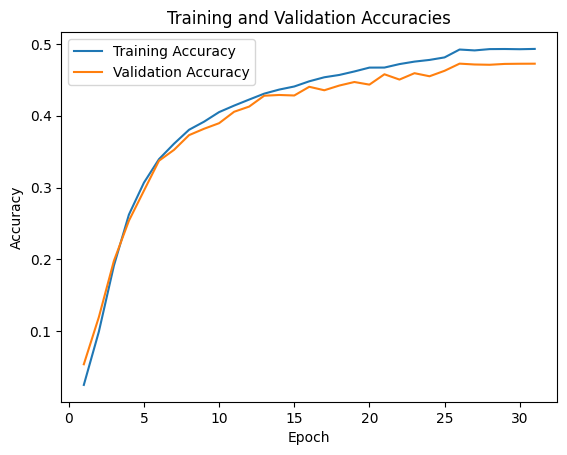

In [103]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

**[5.2]** Let's plot the training and validation losses

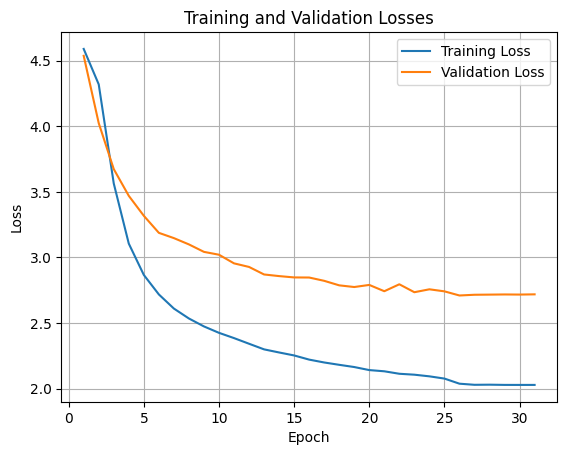

In [104]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

In [105]:
# Save the entire model
torch.save(mobilenet_model, 'mobilenet_model.pth')
